## Libraries

In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from tensorflow.keras import layers, activations
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
##for dirname, _, filenames in os.walk('/kaggle/input'):
##    for filename in filenames:
##        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Preprocessing 

### Preprocessing Class

In [ ]:

class Preprocessor:
    def __init__(self):
        self.df = None

    def load_data(self, file_path):
        self.df = pd.read_csv(file_path)
        display(self.df.head()) 
        return self

    def handle_missing_values(self, column_name):
        self.df[column_name].hist(bins=20, color='skyblue', edgecolor='black')
        plt.title(f"Histogram of '{column_name}'")
        plt.xlabel(column_name)
        plt.ylabel("Frequency")

        missing_info = self.df.isnull().sum()
        print("Missing values per column:")
        print(missing_info)
        self.df[column_name] = self.df[column_name].fillna(self.df[column_name].mean())

        plt.show()

    def remove_outliers_iqr(self, column_name):
        Q1 = self.df[column_name].quantile(0.25)
        Q3 = self.df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = self.df.shape[0]
        self.df = self.df[(self.df[column_name] >= lower_bound) & (self.df[column_name] <= upper_bound)]
        after = self.df.shape[0]
        print(f"Rows before: {before}, Rows after: {after}")
        print(f"Number of outliers: {before-after}")
        return self

    def one_hot_encode(self, column_name):
        self.df = pd.get_dummies(self.df, columns=[column_name], drop_first=True)
        print(f"One-hot encoding applied on '{column_name}'.")
        return self

    def get_features_target(self, target_column):
        y = self.df[target_column]
        X = self.df.drop(columns=[target_column])
        return X, y
    def find_missing_values(self):
        missing_columns = self.df.columns[self.df.isnull().any()].tolist()
        return missing_columns
        
        


In [50]:
file_path = "housing.csv"

processor = Preprocessor()

### Loading dataset

In [51]:
processor.load_data(file_path)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Removing outliers

In [52]:
processor.remove_outliers_iqr("median_house_value")

Rows before: 20640, Rows after: 19569
Number of utliers: 1071


### Finiding missing values

In [6]:
missing_columns =  processor.find_missing_values()
print(missing_columns)

['total_bedrooms']


### Filling missing values

Missing values per column:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        200
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


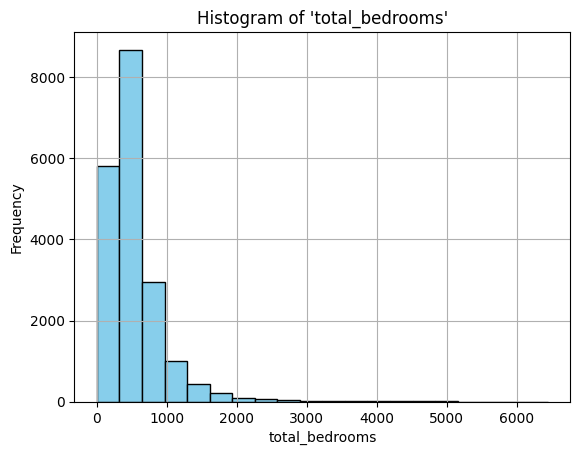

In [7]:
for missing_column in missing_columns:
    processor.handle_missing_values(missing_column)

### One-Hot encoding

In [8]:
processor.one_hot_encode("ocean_proximity")

One-hot encoding applied on 'ocean_proximity'.


### Spliting target features

In [9]:
X, y = processor.get_features_target("median_house_value")
display(X.head())
print(y.head())

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,False,False,True,False


0    452600.0
1    358500.0
2    352100.0
3    341300.0
4    342200.0
Name: median_house_value, dtype: float64


## Neural network

### Fully-Connected neural network class

In [10]:
class FCNN(tf.keras.Model):
    def __init__(self, input_size):
        super(FCNN, self).__init__()
        self.fc1 = layers.Dense(8, input_shape=(input_size,))
        self.relu = layers.ReLU()
        self.fc2 = layers.Dense(1)

    def call(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


### Hyper-Parameters

In [11]:
learning_rate = 0.1
batch_size = 64
epochs = 60
test_validation_rate = 0.2

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanSquaredError()

### Spliting Dataset into Train, Test and Validation

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_validation_rate, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)
input_size = X_train.shape[1]

Train set: (15655, 12) (15655,)
Validation set: (1957, 12) (1957,)
Test set: (1957, 12) (1957,)


### Creating nn Class

In [13]:
model = FCNN(input_size)

In [14]:
model.build((None, input_size))
model.summary()


Model: "fcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  104       
                                                                 
 re_lu (ReLU)                multiple                  0         
                                                                 
 dense_1 (Dense)             multiple                  9         
                                                                 
Total params: 113 (452.00 Byte)
Trainable params: 113 (452.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Training

### Converting datas into numpy array

In [15]:
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
y_val   = np.array(y_val, dtype=np.float32)
X_test   = np.array(X_test, dtype=np.float32)
y_test   = np.array(y_test, dtype=np.float32)


### Creating batches

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)

### Training

In [18]:
def train_custom(model, optimizer, loss_function,train_dataset, val_dataset, test_dataset,epochs):
    train_losses = []
    val_losses = []
    test_losses = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        batches = 0
        for X_batch, y_batch in train_dataset:
            with tf.GradientTape() as tape:
                predictions = model(X_batch, training=True)
                loss = loss_function(y_batch, predictions)
            gradients = tape.gradient(loss, model.trainable_variables)

            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            epoch_loss += loss.numpy()
            batches += 1
        train_loss = epoch_loss / batches
        train_losses.append(train_loss)
        
        val_loss = 0.0
        val_batches = 0
        for X_val_batch, y_val_batch in val_dataset:
            val_pred = model(X_val_batch, training=False)
            val_loss += loss_function(y_val_batch, val_pred).numpy()
            val_batches += 1
        val_loss /= val_batches
        val_losses.append(val_loss)
        
        test_loss = 0.0
        test_batches = 0
        for X_test_batch, y_test_batch in test_dataset:
            test_pred = model(X_test_batch, training=False)
            test_loss += loss_function(y_test_batch, test_pred).numpy()
            test_batches += 1
        test_loss /= test_batches
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] - "
            f"Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, " 
            f"Test Loss: {test_loss:.4f}")
    return train_losses, val_losses, test_losses
train_losses, val_losses, test_losses = train_custom(model, optimizer, loss_function,train_dataset, val_dataset, test_dataset,epochs)

Epoch [1/60] - Train Loss: 9290360679.4449, Val Loss: 8171832154.8387, Test Loss: 7944819216.5161
Epoch [2/60] - Train Loss: 7948225400.1633, Val Loss: 7890829295.4839, Test Loss: 7716085314.0645
Epoch [3/60] - Train Loss: 7727074807.6408, Val Loss: 7630507041.0323, Test Loss: 7480100219.8710
Epoch [4/60] - Train Loss: 7470800788.3755, Val Loss: 7337846255.4839, Test Loss: 7218119828.6452
Epoch [5/60] - Train Loss: 7194847500.5388, Val Loss: 7054460977.5484, Test Loss: 6969059410.5806
Epoch [6/60] - Train Loss: 6922861496.9469, Val Loss: 6787773291.3548, Test Loss: 6720475780.1290
Epoch [7/60] - Train Loss: 6677457949.2571, Val Loss: 6548619495.2258, Test Loss: 6505087917.4194
Epoch [8/60] - Train Loss: 6457099484.4735, Val Loss: 6271093413.1613, Test Loss: 6272646622.9677
Epoch [9/60] - Train Loss: 6230985217.0449, Val Loss: 6016699937.0323, Test Loss: 6073518633.2903
Epoch [10/60] - Train Loss: 6016338949.2245, Val Loss: 5745455715.0968, Test Loss: 5876059334.1935
Epoch [11/60] - Tra

### Plot losses

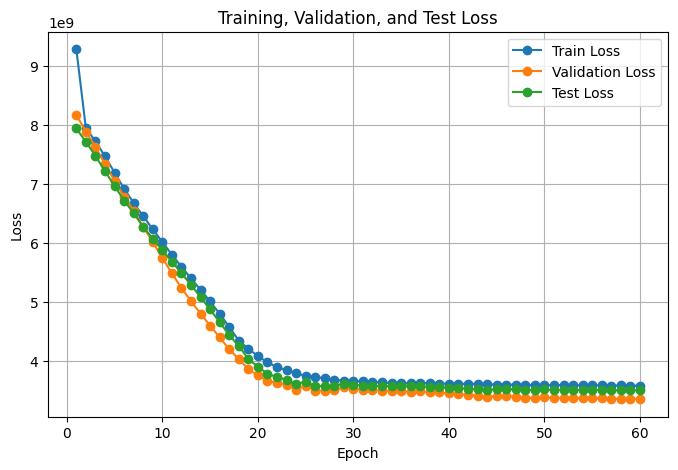

In [19]:
def plot_losses(train_losses, val_losses, test_losses, epochs):
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', marker='o')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation, and Test Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(train_losses, val_losses, test_losses, epochs)


## Evaluate model predictions

In [20]:
def compute_metrics(y_test, y_pred):
    mse = 0.0
    n = len(y_test)

    for i in range(n):
        diff = y_pred[i] - y_test[i]
        mse += diff ** 2

    mse = mse / n 

    rmse = np.sqrt(mse)

    mae = 0.0
    for i in range(n):
        error = abs(y_test[i] - y_pred[i])
        mae += error

    mae = mae / n


    mean_y = 0
    for i in range(n):
        mean_y += y_test[i]
    mean_y /= n

    ss_res = 0
    for i in range(n):
        diff = y_test[i] - y_pred[i]
        ss_res += diff ** 2

    ss_tot = 0
    for i in range(n):
        diff = y_test[i] - mean_y
        ss_tot += diff ** 2

    r2 = 1 - (ss_res / ss_tot)
    
    return mse,rmse,mae,r2


In [ ]:
def show_metrics(model, compute_metrics, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred = model(X_train, training=False).numpy()
    train_mse, train_rmse, train_mae, train_r2 = compute_metrics(y_train, y_train_pred)

    y_val_pred = model(X_val, training=False).numpy()
    val_mse, val_rmse, val_mae, val_r2 = compute_metrics(y_val, y_val_pred)

    y_test_pred = model(X_test, training=False).numpy()
    test_mse, test_rmse, test_mae, test_r2 = compute_metrics(y_test, y_test_pred)


    metrics = {
        "Dataset": ["Train", "Validation", "Test"],
        "MSE": [train_mse, val_mse, test_mse],
        "RMSE": [train_rmse, val_rmse, test_rmse],
        "MAE": [train_mae, val_mae, test_mae],
        "R²": [train_r2, val_r2, test_r2],
    }

    display(pd.DataFrame(metrics))
    return y_test_pred
show_metrics(model, compute_metrics, X_train, y_train, X_val, y_val, X_test, y_test)

,Dataset,MSE,RMSE,MAE,R²
0,Train,[3544396500.0],[59534.836],[45410.168],[0.60934454]
1,Validation,[3364587500.0],[58005.066],[45255.28],[0.64668906]
2,Test,[3506974000.0],[59219.71],[45388.418],[0.6089583]


## Improved neural network

### Improved Fully-connected Class

In [54]:

class ImprovedFCNN(tf.keras.Model):
    def __init__(self, input_size):
        super(ImprovedFCNN, self).__init__()
        self.fc1 = layers.Dense(64, kernel_initializer='he_normal')
        self.bn1 = layers.BatchNormalization()
        self.drop1 = layers.Dropout(0.2)

        self.fc2 = layers.Dense(32, kernel_initializer='he_normal')
        self.bn2 = layers.BatchNormalization()
        self.drop2 = layers.Dropout(0.2)

        self.fc3 = layers.Dense(16, kernel_initializer='he_normal')
        self.bn3 = layers.BatchNormalization()
        self.drop3 = layers.Dropout(0.1)

        self.fc4 = layers.Dense(8, kernel_initializer='he_normal')
        self.bn4 = layers.BatchNormalization()

        self.fc5 = layers.Dense(1)

        self.relu = layers.ReLU()

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.bn1(x, training=training)
        x = self.relu(x)
        x = self.drop1(x, training=training)

        x = self.fc2(x)
        x = self.bn2(x, training=training)
        x = self.relu(x)
        x = self.drop2(x, training=training)

        x = self.fc3(x)
        x = self.bn3(x, training=training)
        x = self.relu(x)
        x = self.drop3(x, training=training)

        x = self.fc4(x)
        x = self.bn4(x, training=training)
        x = self.relu(x)
        
        x = self.fc5(x)
        return x



In [55]:
model = ImprovedFCNN(input_size)

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_function = tf.keras.losses.MeanSquaredError()

In [56]:
model.build((None, input_size))
model.summary()

Model: "improved_fcnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             multiple                  832       
                                                                 
 batch_normalization_4 (Bat  multiple                  256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 dense_8 (Dense)             multiple                  2080      
                                                                 
 batch_normalization_5 (Bat  multiple                  128       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         multiple              

## Training

### Nromalizing Datasets

In [26]:
X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)
X_valid_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()

y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = y_scaler.transform(y_val.reshape(-1, 1))
y_test_scaled  = y_scaler.transform(y_test.reshape(-1, 1))

### Converting to batches

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X_valid_scaled, y_valid_scaled)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled)).batch(batch_size)

### Training

In [29]:
train_losses, val_losses, test_losses = train_custom(model, optimizer, loss_function,train_dataset, val_dataset, test_dataset,epochs)

Epoch [1/60] - Train Loss: 0.4762, Val Loss: 0.3788, Test Loss: 0.4378
Epoch [2/60] - Train Loss: 0.4141, Val Loss: 0.3165, Test Loss: 0.3442
Epoch [3/60] - Train Loss: 0.3918, Val Loss: 0.2979, Test Loss: 0.3355
Epoch [4/60] - Train Loss: 0.3863, Val Loss: 0.3467, Test Loss: 0.3816
Epoch [5/60] - Train Loss: 0.3799, Val Loss: 0.2898, Test Loss: 0.3229
Epoch [6/60] - Train Loss: 0.3727, Val Loss: 0.2917, Test Loss: 0.3225
Epoch [7/60] - Train Loss: 0.3692, Val Loss: 0.3013, Test Loss: 0.3386
Epoch [8/60] - Train Loss: 0.3679, Val Loss: 0.2890, Test Loss: 0.3172
Epoch [9/60] - Train Loss: 0.3623, Val Loss: 0.2890, Test Loss: 0.3174
Epoch [10/60] - Train Loss: 0.3611, Val Loss: 0.2908, Test Loss: 0.3254
Epoch [11/60] - Train Loss: 0.3614, Val Loss: 0.2756, Test Loss: 0.2980
Epoch [12/60] - Train Loss: 0.3543, Val Loss: 0.3059, Test Loss: 0.3302
Epoch [13/60] - Train Loss: 0.3571, Val Loss: 0.2806, Test Loss: 0.3033
Epoch [14/60] - Train Loss: 0.3544, Val Loss: 0.3008, Test Loss: 0.3268
E

### Plot losses

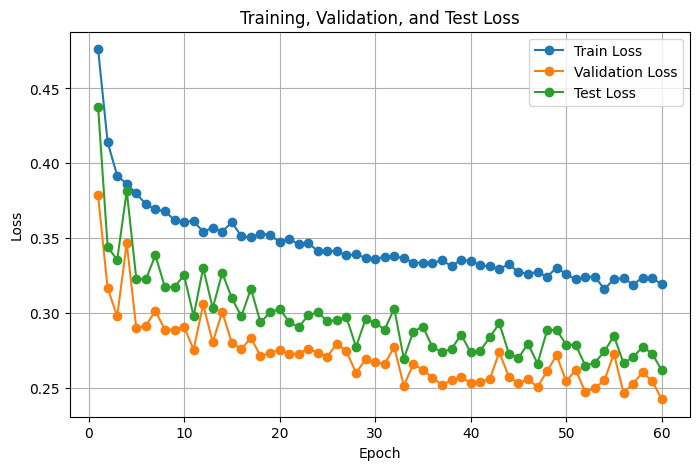

In [30]:
plot_losses(train_losses, val_losses, test_losses, epochs)

## Evaluate model predictions

In [ ]:
y_pred = show_metrics(model, compute_metrics, X_train_scaled, y_train_scaled, X_valid_scaled, y_valid_scaled, X_test_scaled, y_test_scaled)

,Dataset,MSE,RMSE,MAE,R²
0,Train,[0.25805414],[0.5079903],[0.35173258],[0.7419449]
1,Validation,[0.24360327],[0.49356183],[0.3461919],[0.76790965]
2,Test,[0.26245004],[0.51229876],[0.35570148],[0.7344872]


### Actual vs Predicted Plot

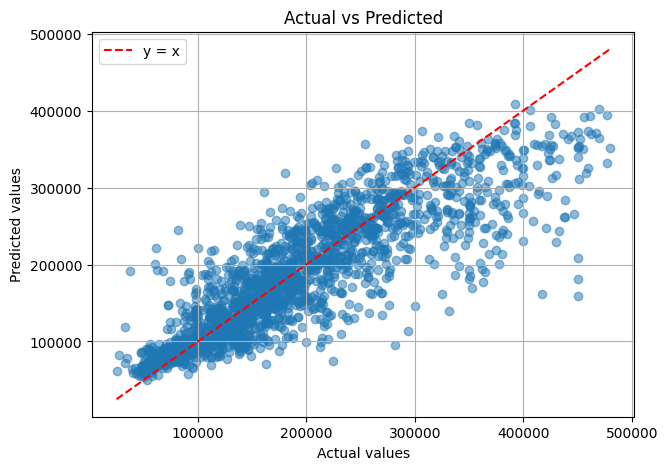

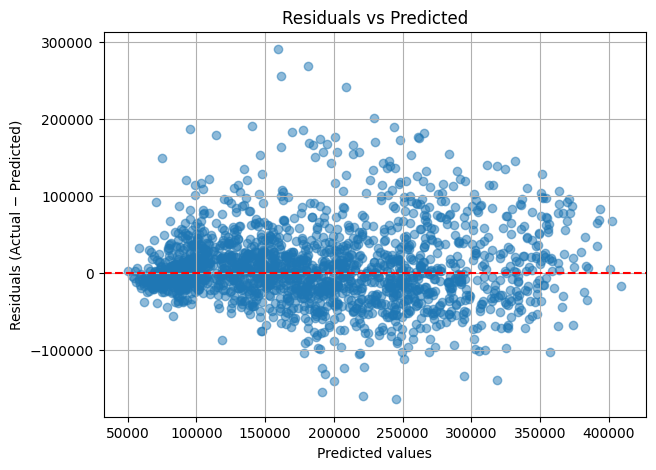

In [44]:
def plot_actual_vs_predicted_and_residuals(y_true,y_pred):
    y_true = np.array(y_true).ravel()
    y_pred = np.array(y_pred).ravel()
    
    plt.figure(figsize=(7,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
    plt.xlabel(f"Actual values")
    plt.ylabel(f"Predicted values")
    plt.title(f"Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    residuals = y_true - y_pred
    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f"Predicted values")
    plt.ylabel("Residuals (Actual − Predicted)")
    plt.title(f"Residuals vs Predicted")
    plt.grid(True)
    plt.show()
plot_actual_vs_predicted_and_residuals(y_test,y_pred)